In [53]:
%matplotlib inline

import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
import operator
from sklearn.cross_validation import train_test_split
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig
from sklearn.metrics import log_loss, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler

RS = 12357
ROUNDS = 315

print("Started")
np.random.seed(RS)
input_folder = '../kaggle-quora/data/'

Started


In [2]:
def train_xgb(X, y, params):
    print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS)

    xg_train = xgb.DMatrix(x, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    watchlist  = [(xg_train,'train'), (xg_val,'eval')]
    return xgb.train(params, xg_train, ROUNDS, watchlist)

def predict_xgb(clr, X_test):
    return clr.predict(xgb.DMatrix(X_test))

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

In [3]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller

def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

def word_shares(row):
    q1_list = str(row['question1']).lower().split()
    q1 = set(q1_list)
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0:0:0:0'

    q2_list = str(row['question2']).lower().split()
    q2 = set(q2_list)
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0:0:0:0'

    words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])

    shared_2gram = q1_2gram.intersection(q2_2gram)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    q1_weights = [weights.get(w, 0) for w in q1words]
    q2_weights = [weights.get(w, 0) for w in q2words]
    total_weights = q1_weights + q1_weights

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
    Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
    if len(q1_2gram) + len(q2_2gram) == 0:
        R2gram = 0
    else:
        R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
    return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)

In [4]:
%%time

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['silent'] = 1
params['seed'] = RS

df_train = pd.read_csv(input_folder + 'train.csv')
df_test  = pd.read_csv(input_folder + 'test.csv')

print("Original data: X_train: {}, X_test: {}".format(df_train.shape, df_test.shape))
print("Features processing, be patient...")


train_qs = pd.Series(df_train['question1'].tolist() + \
                     df_train['question2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words("english"))


df = pd.concat([df_train, df_test])
df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

Original data: X_train: (404290, 6), X_test: (2345796, 3)
Features processing, be patient...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 4min 50s, sys: 5.97 s, total: 4min 56s
Wall time: 4min 58s


In [5]:
%%time

x = pd.DataFrame()

x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['word_match_2root'] = np.sqrt(x['word_match'])
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['shared_2gram']     = df['word_shares'].apply(lambda x: float(x.split(':')[5]))
x['cosine']           = df['word_shares'].apply(lambda x: float(x.split(':')[6]))
x['words_hamming']    = df['word_shares'].apply(lambda x: float(x.split(':')[7]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

x['len_q1'] = df['question1'].apply(lambda x: len(str(x)))
x['len_q2'] = df['question2'].apply(lambda x: len(str(x)))
x['diff_len'] = x['len_q1'] - x['len_q2']

x['caps_count_q1'] = df['question1'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['caps_count_q2'] = df['question2'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['diff_caps'] = x['caps_count_q1'] - x['caps_count_q2']

x['len_char_q1'] = df['question1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = df['question2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = df['question2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
x['duplicated'] = df.duplicated(['question1','question2']).astype(int)

CPU times: user 1min 19s, sys: 1.58 s, total: 1min 21s
Wall time: 1min 21s


# Add Magic Features.

In [6]:
%%time

train_combine = pd.read_csv('../kaggle-quora/features/train_magic.csv', header=0)
test_combine = pd.read_csv('../kaggle-quora/features/test_magic.csv', header=0)
df_combine = pd.concat([train_combine, test_combine])
x['q1_freq'] = df_combine['q1_freq']
x['q2_freq'] = df_combine['q2_freq']

CPU times: user 992 ms, sys: 208 ms, total: 1.2 s
Wall time: 1.21 s


# Other Features

In [7]:
%%time

add_word_count(x, df,'how')
add_word_count(x, df,'what')
add_word_count(x, df,'which')
add_word_count(x, df,'who')
add_word_count(x, df,'where')
add_word_count(x, df,'when')
add_word_count(x, df,'why')

print(x.columns)
print(x.describe())

Index(['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count',
       'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine',
       'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len',
       'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1',
       'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2',
       'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word',
       'exactly_same', 'duplicated', 'q1_freq', 'q2_freq', 'q1_how', 'q2_how',
       'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which',
       'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where',
       'where_both', 'q1_when', 'q2_when', 'when_both', 'q1_why', 'q2_why',
       'why_both'],
      dtype='object')
         word_match  word_match_2root  tfidf_word_match  shared_count  \
count  2.744371e+06      2.744371e+06      2.750086e+06  2.750086e+06   
mean   1.542752e-01      3.228801e-01      2.016003e-01  1.605620e+00   


# Oversampling and Train/Test Split

In [8]:
%%time

feature_names = list(x.columns.values)
create_feature_map(feature_names)
print("Features: {}".format(feature_names))

x_train = x[:df_train.shape[0]]
x_test  = x[df_train.shape[0]:]
y_train = df_train['is_duplicate'].values
del x, df_train

if 1: # Now we oversample the negative class - on your own risk of overfitting!
    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    print("Oversampling started for proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print("Oversampling done, new proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))

    x_train = pd.concat([pos_train, neg_train])
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
    del pos_train, neg_train

Features: ['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count', 'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine', 'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len', 'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1', 'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2', 'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word', 'exactly_same', 'duplicated', 'q1_freq', 'q2_freq', 'q1_how', 'q2_how', 'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1_when', 'q2_when', 'when_both', 'q1_why', 'q2_why', 'why_both']
Oversampling started for proportion: 0.369197853026293
Oversampling done, new proportion: 0.19124366100096607
CPU times: user 735 ms, sys: 893 ms, total: 1.63 s
Wall time: 1.63 s


In [15]:
print(type(x_train), '\n')
print(x_train.shape)
print(len(y_train))

<class 'pandas.core.frame.DataFrame'> 

(780486, 50)
780486


In [10]:
x_test.head()

,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,...,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
0,0.176680,0.420334,0.153846,2.0,0.833333,0.444444,0.043478,0.287964,0.000000,0.388889,...,0,0,0,0,0,0,0,0,1,0
1,0.212054,0.460493,0.333333,3.0,1.000000,0.400000,0.105263,0.464290,0.142857,0.600000,...,0,0,0,0,0,0,0,0,0,0
2,0.191159,0.437218,0.285714,2.0,1.000000,1.000000,0.055556,0.464872,0.071429,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.0,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,...,0,0,0,0,0,0,0,0,0,0
4,0.500000,0.707107,0.666667,2.0,0.333333,2.000000,0.125000,1.000000,0.166667,-1.666667,...,0,0,0,0,0,0,0,0,0,0


In [11]:
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())
np.sum(x_test.isnull())

word_match          0
word_match_2root    0
tfidf_word_match    0
shared_count        0
stops1_ratio        0
stops2_ratio        0
shared_2gram        0
cosine              0
words_hamming       0
diff_stops_r        0
len_q1              0
len_q2              0
diff_len            0
caps_count_q1       0
caps_count_q2       0
diff_caps           0
len_char_q1         0
len_char_q2         0
diff_len_char       0
len_word_q1         0
len_word_q2         0
diff_len_word       0
avg_world_len1      0
avg_world_len2      0
diff_avg_word       0
exactly_same        0
duplicated          0
q1_freq             0
q2_freq             0
q1_how              0
q2_how              0
how_both            0
q1_what             0
q2_what             0
what_both           0
q1_which            0
q2_which            0
which_both          0
q1_who              0
q2_who              0
who_both            0
q1_where            0
q2_where            0
where_both          0
q1_when             0
q2_when   

# Save the features.

In [112]:
%%time

pd.to_pickle(x_train, "./train_jaccard_magic_features.pkl")
pd.to_pickle(x_test, "./test_jaccard_magic_features.pkl")

x_train.to_csv('./train_jaccard_magic_features.csv')
x_test.to_csv('./test_jaccard_magic_features.csv')

pd.DataFrame(data=y_train).to_csv('./y_train_oversampled.csv', index=False)

CPU times: user 1min 56s, sys: 6.99 s, total: 2min 3s
Wall time: 2min 8s


# Prepare for 3 fold stacking

In [53]:
from sklearn import model_selection

skf = model_selection.StratifiedKFold(n_splits=3, random_state=None)
folds = skf.split(x_train, y_train)
_, fold1_index = next(folds)
_, fold2_index = next(folds)
_, validation_index = next(folds)

In [79]:
pd.DataFrame(data=fold1_index).to_csv('./fold1_index.csv', index=False)
pd.DataFrame(data=fold2_index).to_csv('./fold2_index.csv', index=False)
pd.DataFrame(data=validation_index).to_csv('./validation_index.csv', index=False)

In [61]:
print(fold1_index.shape)
print(fold2_index.shape)
print(validation_index.shape)

(260163,)
(260162,)
(260161,)


In [74]:
train_fold1 = x_train.iloc[fold1_index, :]
train_fold2 = x_train.iloc[fold2_index, :]
validation_fold = x_train.iloc[validation_index, :]

y_train_fold1 = pd.DataFrame(data=y_train).iloc[fold1_index, :]
y_train_fold2 = pd.DataFrame(data=y_train).iloc[fold2_index, :]
y_validation_fold = pd.DataFrame(data=y_train).iloc[validation_index, :]

In [2]:
#####################################
### Use this cell if loading data ###
#####################################

fold1_index = pd.read_csv('./index/fold1_index.csv')
fold2_index = pd.read_csv('./index/fold2_index.csv')
validation_index = pd.read_csv('./index/validation_index.csv')

x_train = pd.read_csv('../kaggle-quora/features/train_jaccard_magic_features.csv')
y_train = pd.read_csv('../kaggle-quora/data/y_train_oversampled.csv')

train_fold1 = x_train.loc[fold1_index.values.flatten(), :]
train_fold2 = x_train.loc[fold2_index.values.flatten(), :]
validation_fold = x_train.loc[validation_index.values.flatten(), :]

y_train_fold1 = y_train.loc[fold1_index.values.flatten(), :]
y_train_fold2 = y_train.loc[fold2_index.values.flatten(), :]
y_validation_fold = y_train.loc[validation_index.values.flatten(), :]

In [3]:
print(y_train_fold1['0'].value_counts())
print(y_train_fold2['0'].value_counts())
print(y_validation_fold['0'].value_counts())

0.0    210408
1.0     49755
Name: 0, dtype: int64
0.0    210408
1.0     49754
Name: 0, dtype: int64
0.0    210407
1.0     49754
Name: 0, dtype: int64


In [77]:
def get_2fold_stack(model):
    xg_train_fold1 = xgb.DMatrix(train_fold1, label=y_train_fold1)
    xg_train_fold2 = xgb.DMatrix(train_fold2, label=y_train_fold2)
    xg_val = xgb.DMatrix(validation_fold, label=y_validation_fold)
    
    watchlist_fold1  = [(xg_train_fold1, 'train'), (xg_val, 'eval')]
    watchlist_fold2  = [(xg_train_fold2, 'train'), (xg_val, 'eval')]
    
    clf1 = model.train(params, xg_train_fold1, ROUNDS, watchlist_fold1)
    new_fold2 = clf1.predict(xg_train_fold2)
    v1 = clf1.predict(xg_val)

    clf2 = model.train(params, xg_train_fold2, ROUNDS, watchlist_fold2)
    new_fold1 = clf2.predict(xg_train_fold1)
    v2 = clf2.predict(xg_val)
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

In [78]:
###############
### XGBoost ###
###############

%%time

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['silent'] = 1
params['seed'] = RS

layer_1_train, layer_1_val = get_2fold_stack(xgb)

[0]	train-logloss:0.629312	eval-logloss:0.629403
[1]	train-logloss:0.57803	eval-logloss:0.578199
[2]	train-logloss:0.535662	eval-logloss:0.535892
[3]	train-logloss:0.500716	eval-logloss:0.501025
[4]	train-logloss:0.470908	eval-logloss:0.471321
[5]	train-logloss:0.446152	eval-logloss:0.446638
[6]	train-logloss:0.424759	eval-logloss:0.425335
[7]	train-logloss:0.40648	eval-logloss:0.407123
[8]	train-logloss:0.390748	eval-logloss:0.39145
[9]	train-logloss:0.376592	eval-logloss:0.377335
[10]	train-logloss:0.364415	eval-logloss:0.365211
[11]	train-logloss:0.353374	eval-logloss:0.354224
[12]	train-logloss:0.344412	eval-logloss:0.345308
[13]	train-logloss:0.336216	eval-logloss:0.337178
[14]	train-logloss:0.329425	eval-logloss:0.330433
[15]	train-logloss:0.323138	eval-logloss:0.324205
[16]	train-logloss:0.317568	eval-logloss:0.318683
[17]	train-logloss:0.312817	eval-logloss:0.313977
[18]	train-logloss:0.30797	eval-logloss:0.309169
[19]	train-logloss:0.303414	eval-logloss:0.304662
[20]	train-log

[164]	train-logloss:0.247873	eval-logloss:0.254421
[165]	train-logloss:0.247826	eval-logloss:0.2544
[166]	train-logloss:0.247754	eval-logloss:0.254364
[167]	train-logloss:0.247712	eval-logloss:0.254337
[168]	train-logloss:0.247614	eval-logloss:0.254257
[169]	train-logloss:0.247598	eval-logloss:0.254252
[170]	train-logloss:0.247586	eval-logloss:0.254249
[171]	train-logloss:0.247504	eval-logloss:0.254193
[172]	train-logloss:0.247274	eval-logloss:0.254009
[173]	train-logloss:0.247228	eval-logloss:0.253986
[174]	train-logloss:0.247117	eval-logloss:0.253905
[175]	train-logloss:0.246981	eval-logloss:0.253823
[176]	train-logloss:0.246859	eval-logloss:0.253739
[177]	train-logloss:0.246688	eval-logloss:0.253634
[178]	train-logloss:0.246495	eval-logloss:0.253479
[179]	train-logloss:0.246421	eval-logloss:0.253428
[180]	train-logloss:0.246244	eval-logloss:0.253277
[181]	train-logloss:0.245979	eval-logloss:0.253044
[182]	train-logloss:0.245902	eval-logloss:0.252982
[183]	train-logloss:0.245888	eval

[11]	train-logloss:0.354788	eval-logloss:0.354507
[12]	train-logloss:0.345914	eval-logloss:0.345645
[13]	train-logloss:0.337588	eval-logloss:0.337315
[14]	train-logloss:0.330385	eval-logloss:0.330119
[15]	train-logloss:0.323741	eval-logloss:0.323507
[16]	train-logloss:0.317577	eval-logloss:0.317408
[17]	train-logloss:0.312917	eval-logloss:0.312799
[18]	train-logloss:0.308143	eval-logloss:0.308036
[19]	train-logloss:0.303735	eval-logloss:0.303669
[20]	train-logloss:0.300246	eval-logloss:0.300218
[21]	train-logloss:0.297374	eval-logloss:0.297417
[22]	train-logloss:0.294652	eval-logloss:0.294734
[23]	train-logloss:0.292042	eval-logloss:0.292147
[24]	train-logloss:0.290075	eval-logloss:0.290213
[25]	train-logloss:0.287769	eval-logloss:0.28793
[26]	train-logloss:0.28613	eval-logloss:0.286354
[27]	train-logloss:0.284569	eval-logloss:0.284878
[28]	train-logloss:0.28304	eval-logloss:0.283375
[29]	train-logloss:0.281719	eval-logloss:0.282129
[30]	train-logloss:0.280512	eval-logloss:0.280972
[31

[174]	train-logloss:0.248158	eval-logloss:0.253825
[175]	train-logloss:0.248035	eval-logloss:0.253743
[176]	train-logloss:0.247919	eval-logloss:0.253656
[177]	train-logloss:0.247836	eval-logloss:0.253593
[178]	train-logloss:0.247681	eval-logloss:0.25349
[179]	train-logloss:0.247554	eval-logloss:0.253409
[180]	train-logloss:0.247466	eval-logloss:0.253348
[181]	train-logloss:0.247438	eval-logloss:0.253336
[182]	train-logloss:0.247394	eval-logloss:0.253324
[183]	train-logloss:0.247308	eval-logloss:0.253277
[184]	train-logloss:0.247201	eval-logloss:0.253213
[185]	train-logloss:0.247001	eval-logloss:0.253046
[186]	train-logloss:0.246858	eval-logloss:0.252939
[187]	train-logloss:0.246746	eval-logloss:0.252877
[188]	train-logloss:0.24672	eval-logloss:0.252867
[189]	train-logloss:0.246691	eval-logloss:0.252848
[190]	train-logloss:0.246637	eval-logloss:0.252815
[191]	train-logloss:0.246625	eval-logloss:0.252813
[192]	train-logloss:0.246581	eval-logloss:0.252792
[193]	train-logloss:0.246481	eval

In [62]:
###########################
### Logistic Regression ###
###########################

from sklearn.linear_model import LogisticRegression

# scaler = MinMaxScaler()
# train_fold1_scaled = scaler.fit_transform(train_fold1)
# train_fold2_scaled = scaler.fit_transform(train_fold2)
# validation_fold_scaled = scaler.fit_transform(validation_fold)

def get_2fold_stack_logit(model):
    model.fit(train_fold1_scaled, y_train_fold1)
    new_fold2 = model.predict_proba(train_fold2_scaled)
    v1 = model.predict_proba(validation_fold_scaled)  ### There is model

    model.fit(train_fold2_scaled, y_train_fold2)
    new_fold1 = model.predict_proba(train_fold1_scaled)
    v2 = model.predict_proba(validation_fold_scaled) ### The model here is different
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

In [65]:
%%time

logit = LogisticRegression(verbose=10)
logit_layer_1_train, logit_layer_1_val = get_2fold_stack_logit(logit)

[LibLinear][LibLinear]CPU times: user 7.39 s, sys: 187 ms, total: 7.57 s
Wall time: 7.54 s


In [66]:
print('The log loss is: %.3f' % log_loss(y_validation_fold, logit_layer_1_val))

The log loss is: 0.439


In [89]:
##########################
### Factorized Machine ###
##########################
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csc_matrix
from fastFM import sgd, mcmc
from fastFM.datasets import make_user_item_regression


# train_fold1 = x_train.loc[fold1_index.values.flatten(), :]
# train_fold2 = x_train.loc[fold2_index.values.flatten(), :]
# validation_fold = x_train.loc[validation_index.values.flatten(), :]

# y_train_fold1 = y_train.loc[fold1_index.values.flatten(), :]
# y_train_fold2 = y_train.loc[fold2_index.values.flatten(), :]
# y_validation_fold = y_train.loc[validation_index.values.flatten(), :]

scaler = MinMaxScaler()
train_fold1_scaled = scaler.fit_transform(train_fold1)
train_fold2_scaled = scaler.fit_transform(train_fold2)
validation_fold_scaled = scaler.fit_transform(validation_fold)

n_iter = 1000
step_size = 1

In [90]:
fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0.8,
                          l2_reg_V=0.8, rank=2, step_size=0.01)

In [ ]:
fm_mcmc = mcmc.FMClassification(n_iter=1000, init_stdev=0.1, rank=2)

In [91]:
y_labels = np.ones_like(y_train_fold1['0'])
y_labels[y_train_fold1['0'] < np.mean(y_train_fold1['0'])] = -1

print(y_train_fold1['0'].value_counts())
print(pd.Series(data=y_labels).value_counts())

0.0    210408
1.0     49755
Name: 0, dtype: int64
-1.0    210408
 1.0     49755
dtype: int64


In [ ]:
%%time

new_fold2 = fm_mcmc.fit_predict_proba(csc_matrix(train_fold1_scaled), y_labels, csc_matrix(train_fold2_scaled))
v1 = fm_mcmc.fit_predict_proba(csc_matrix(train_fold1_scaled), y_labels, csc_matrix(validation_fold_scaled))

In [ ]:
%%time

logloss_train = []
logloss_val = []
for i in range(1, n_iter):
    fm.fit(csc_matrix(train_fold1_scaled), y_labels)
    new_fold1 = fm.predict_proba(csc_matrix(train_fold1_scaled))
    v1 = fm.predict_proba(csc_matrix(validation_fold_scaled))
    
    logloss_train.append(log_loss(y_train_fold1, new_fold1))
    logloss_val.append(log_loss(y_validation_fold, v1))

# fm.fit(csc_matrix(train_fold1_scaled), y_labels)
# new_fold2 = fm.predict_proba(csc_matrix(train_fold2_scaled))
# v1 = fm.predict_proba(csc_matrix(validation_fold_scaled))

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

x = np.arange(1, n_iter) * step_size
with plt.style.context('fivethirtyeight'):
    axes[0].plot(x, logloss_train, label='logloss-train', color='r', ls="--")
    axes[0].plot(x, logloss_val, label='logloss-test', color='r')
axes[0].set_ylabel('logloss', color='r')
axes[0].legend()

In [87]:
print(log_loss(y_train_fold2, new_fold2))
print(log_loss(y_validation_fold, v1))

3.34532516261
3.34121657739


In [95]:
##########################
### Factorized Machine ###
##########################

from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt,pow
import itertools
import math
from random import random,shuffle,uniform,seed
import pickle
import sys

In [97]:
def data_generator(path, no_norm=False, task='c'):
    ''' Unfold compressed data into matrix.'''
    data = open(path,'r')
    for row in data:
        row = row.strip().split(" ")
        y = float(row[0])
        row = row[1:]
        x = []
        for feature in row:
            feature = feature.split(":")
            idx = int(feature[0])
            value = float(feature[1])
            x.append([idx,value])

        if not no_norm:
            r = 0.0
            for i in range(len(x)):
                r+=x[i][1]*x[i][1]
            for i in range(len(x)):
                x[i][1] /=r
        # if task=='c':
        #     if y ==0.0:
        #         y = -1.0

        yield x, y


def dot(u,v):
    u_v = 0.
    len_u = len(u)
    for idx in range(len_u):
        uu = u[idx]
        vv = v[idx]
        u_v += uu*vv
    return u_v

def mse_loss_function(y,p):
    return (y - p)**2

def mae_loss_function(y,p):
    y = exp(y)
    p = exp(p)
    return abs(y - p)

def log_loss_function(y,p):
    return -(y*log(p)+(1-y)*log(1-p))

def exponential_loss_function(y,p):
    return log(1+exp(-y*p))

def sigmoid(inX):
    return 1/(1+exp(-inX))

def bounded_sigmoid(inX):
    return 1. / (1. + exp(-max(min(inX, 35.), -35.)))

class SGD(object):
    def __init__(self, lr=0.001, momentum=0.9, nesterov=True, adam=False, l2=0.0, \
                 l2_fm=0.0, l2_bias=0.0, ini_stdev= 0.01, dropout=0.5, task='c', \
                 n_components=4, nb_epoch=5, interaction=False, no_norm=False):

        self.W = []
        self.V = []        
        self.bias = uniform(-ini_stdev, ini_stdev)
        self.n_components=n_components
        self.lr = lr # learning rate
        self.l2 = l2
        self.l2_fm = l2_fm
        self.l2_bias = l2_bias
        self.momentum = momentum
        self.nesterov = nesterov
        self.adam = adam
        self.nb_epoch = nb_epoch
        self.ini_stdev = ini_stdev
        self.task = task
        self.interaction = interaction
        self.dropout = dropout
        self.no_norm = no_norm
        if self.task!='c':
            # self.loss_function = mse_loss_function
            self.loss_function = mae_loss_function
        else:
            # self.loss_function = exponential_loss_function
            self.loss_function = log_loss_function

    def preload(self, train, test):
        train = data_generator(train, self.no_norm, self.task)
        dim = 0
        count = 0
        for x, y in train:
            for i in x:
                idx, value = i
                if idx > dim:
                    dim = idx
            count+=1
        print('Training samples:',count)
        test = data_generator(test,self.no_norm,self.task)
        count=0
        for x,y in test:
            for i in x:
                idx,value = i
                if idx >dim:
                    dim = idx
            count+=1
        print('Testing samples:', count)
        
        dim = dim + 1
        print("Number of features:", dim)
        
        self.W = [uniform(-self.ini_stdev, self.ini_stdev) for _ in range(dim)]
        self.Velocity_W = [0.0 for _ in range(dim)]
        
        
        self.V = [[uniform(-self.ini_stdev, self.ini_stdev) for _ in range(self.n_components)] for _ in range(dim)]
        self.Velocity_V = [[0.0 for _ in range(self.n_components)] for _ in range(dim)]
        
        self.Velocity_bias = 0.0
        
        self.dim = dim
        
        
    def adam_init(self):
        self.iterations = 0
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon=1e-8
        self.decay = 0.
        self.inital_decay = self.decay 

        dim =self.dim

        self.m_W = [0.0 for _ in range(dim)]
        self.v_W = [0.0 for _ in range(dim)]

        self.m_V = [[0.0 for _ in range(self.n_components)] for _ in range(dim)]
        self.v_V = [[0.0 for _ in range(self.n_components)] for _ in range(dim)]

        self.m_bias = 0.0
        self.v_bias = 0.0


    def adam_update(self,lr,x,residual):

        if 0. < self.dropout < 1.:
            self.droupout_x(x)
        
        lr = self.lr
        if self.inital_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1

        lr_t = lr * sqrt(1. - pow(self.beta_2, t)) / (1. - pow(self.beta_1, t))
        
        for sample in x:
            idx,value = sample
            g = residual*value

            m = self.m_W[idx]
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g

            v = self.v_W[idx]
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * (g**2)

            p = self.W[idx]
            p_t = p - lr_t *m_t / (sqrt(v_t) + self.epsilon)

            if self.l2>0:
                p_t = p_t - lr_t*self.l2*p

            self.m_W[idx] = m_t
            self.v_W[idx] = v_t
            self.W[idx] = p_t

        if self.interaction:
            self._adam_update_fm(lr_t,x,residual)


        m = self.m_bias
        m_t = (self.beta_1 * m) + (1. - self.beta_1)*residual

        v = self.v_bias
        v_t = (self.beta_2 * v) + (1. - self.beta_2)*(residual**2)

        p = self.bias
        p_t = p - lr_t * m_t / (sqrt(v_t) + self.epsilon)
        if self.l2_bias > 0:
            pt = pt - lr_t * self.l2_bias*p

        self.m_bias = m_t
        self.v_bias = v_t
        self.bias = p_t

        self.iterations+=1

    def _adam_update_fm(self,lr_t,x,residual):
        len_x = len(x)
        sum_f_dict = self.sum_f_dict
        n_components = self.n_components
        for f in range(n_components):
            for i in range(len_x):
                idx_i,value_i = x[i]
                v = self.V[idx_i][f]
                sum_f = sum_f_dict[f]
                g = (sum_f*value_i - v *value_i*value_i)*residual

                m = self.m_V[idx_i][f]
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g

                v = self.v_V[idx_i][f]
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * (g**2)

                p = self.V[idx_i][f]
                p_t = p - lr_t * m_t / (sqrt(v_t) + self.epsilon)

                if self.l2_fm>0:
                    p_t = p_t - lr_t * self.l2_fm*p

                self.m_V[idx_i][f] = m_t
                self.v_V[idx_i][f] = v_t
                self.V[idx_i][f] = p_t

    def droupout_x(self, x):
        new_x = []
        for i, var in enumerate(x):
            if random() > self.dropout:
                del x[i]

    def _predict_fm(self, x):
        len_x = len(x)
        n_components = self.n_components
        pred = 0.0
        self.sum_f_dict = {}
        for f in range(n_components):
            sum_f = 0.0
            sum_sqr_f = 0.0
            for i in range(len_x):
                idx_i,value_i = x[i]
                d = self.V[idx_i][f] * value_i
                sum_f +=d
                sum_sqr_f +=d*d
            pred+= 0.5 * (sum_f*sum_f - sum_sqr_f);
            self.sum_f_dict[f] = sum_f
        return pred

    def _predict_one(self, x):
        pred = self.bias
        # pred = 0.0
        for idx,value in x:
            pred+=self.W[idx]*value
        
        if self.interaction:
            pred+=self._predict_fm(x)

        if self.task=='c':
            pred = bounded_sigmoid(pred)
        return pred


    def _update_fm(self, lr, x, residual):
        len_x = len(x)
        sum_f_dict = self.sum_f_dict
        n_components = self.n_components
        for f in range(n_components):
            for i in range(len_x):
                idx_i,value_i = x[i]
                sum_f = sum_f_dict[f]
                v = self.V[idx_i][f]
                grad = (sum_f*value_i - v *value_i*value_i)*residual
                
                self.Velocity_V[idx_i][f] = self.momentum * self.Velocity_V[idx_i][f] - lr * grad
                if self.nesterov:
                    self.Velocity_V[idx_i][f] = self.momentum * self.Velocity_V[idx_i][f] - lr * grad
                self.V[idx_i][f] = self.V[idx_i][f] + self.Velocity_V[idx_i][f] - lr*self.l2_fm*self.V[idx_i][f]



    def update(self, lr, x, residual):

        if 0. < self.dropout < 1.:
            self.droupout_x(x)

        for sample in x:
            idx, value = sample
            grad = residual * value
            self.Velocity_W[idx] =  self.momentum * self.Velocity_W[idx] - lr * grad
            if self.nesterov:
                 self.Velocity_W[idx] = self.momentum * self.Velocity_W[idx] - lr * grad
            self.W[idx] = self.W[idx] + self.Velocity_W[idx] - lr * self.l2 * self.W[idx]
            
        if self.interaction:
            self._update_fm(lr, x, residual)

        self.Velocity_bias = self.momentum * self.Velocity_bias - lr * residual
        if self.nesterov:
            self.Velocity_bias = self.momentum * self.Velocity_bias - lr * residual
        self.bias = self.bias + self.Velocity_bias - lr * self.l2_bias * self.bias

    def predict(self, path, out):

        data = data_generator(path, self.no_norm,self.task)
        y_preds =[]
        with open(out, 'w') as outfile:
            ID = 0
            outfile.write('%s,%s\n' % ('test_id', 'is_duplicate'))
            for d in data:
                x, y = d
                p = self._predict_one(x)
                outfile.write('%s,%s\n' % (ID, str(p)))
                ID+=1


    def validate(self, path):
        data = data_generator(path, self.no_norm, self.task)
        loss = 0.0
        count = 0.0

        for d in data:
            x,y = d
            p = self._predict_one(x)
            loss+=self.loss_function(y,p)
            count+=1
        return loss/count

    def save_weights(self):
        weights = []
        weights.append(self.W)
        weights.append(self.V)
        weights.append(self.bias)
        # weights.append(self.Velocity_W)
        # weights.append(self.Velocity_V)
        weights.append(self.dim)
        pickle.dump(weights, open('sgd_fm.pkl','wb'))

    def load_weights(self):
        weights = pickle.load(open('sgd_fm.pkl','rb'))
        self.W = weights[0]
        self.V = weights[1]
        self.bias = weights[2]
        # self.Velocity_W = weights[3]
        # self.Velocity_V = weights[4]
        self.dim = weights[3]
        

    def train(self, path, valid_path=None, in_memory=False):

        start = datetime.now()
        lr = self.lr
        if self.adam:
            self.adam_init()
            self.update = self.adam_update

        if in_memory:
            data = data_generator(path, self.no_norm, self.task) # Unfold compressed data into matrix.
            data = [d for d in data]
            
        best_loss = 999999
        best_epoch = 0
        early_stop_count = 0
        for epoch in range(1, self.nb_epoch+1): # Training through the epochs.
            if not in_memory:
                data = data_generator(path, self.no_norm, self.task)
            train_loss = 0.0
            train_count = 0
            for x, y in data: # Training through the whole batch.
                p = self._predict_one(x)
                if self.task != 'c':                    
                    residual = -(y-p)
                else:
                    # residual = -y*(1.0-1.0/(1.0+exp(-y*p)));
                    residual = -(y-p)

                self.update(lr, x, residual)
                if train_count % 50000 == 0:
                    if train_count == 0:
                        print('\ttrain_count: %s, current loss: %.6f'%(train_count, 0.0))
                    else:
                        print('\ttrain_count: %s, current loss: %.6f'%(train_count, train_loss/train_count))

                train_loss += self.loss_function(y,p)
                train_count += 1

            epoch_end = datetime.now()
            duration = epoch_end - start
            
            # Early Stopping: save weights of the best epoch.
            if valid_path:
                valid_loss = self.validate(valid_path)
                print('Epoch: %s, train loss: %.6f, valid loss: %.6f, time: %s'%(epoch, train_loss/train_count,valid_loss, duration))
                print('early_stop_count: ', early_stop_count)
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    self.save_weights()
                    early_stop_count = 0                    
                    print('save_weights')
                else:
                    early_stop_count = early_stop_count + 1

            else:
                print('Epoch: %s, train loss: %.6f, time: %s'%(epoch,train_loss/train_count,duration))
            
            if early_stop_count >= 3:
                break

In [109]:
path = "../kaggle-quora/data/"

sgd = SGD(lr=0.0001, \
          adam=True, \
          dropout=0.8, \
          l2=0.00, \
          l2_fm=0.00, \
          task='c', \
          n_components=1, \
          nb_epoch=30, \
          interaction=True, \
          no_norm=False)

In [110]:
def get_2fold_stack_fm():
    sgd.preload(path + 'X_fold1_tfidf_jacad_magic.svm', path + 'X_valid_tfidf_jacad_magic.svm')
    sgd.train(path + 'X_fold1_tfidf_jacad_magic.svm', path + 'X_valid_tfidf_jacad_magic.svm', in_memory=False)
    sgd.load_weights()
    new_fold2 = sgd.predict(path + 'X_fold2_tfidf_jacad_magic.svm', out='fold2_jacad_magic.csv')
    v1 = sgd.predict(path + 'X_valid_tfidf_jacad_magic.svm', out='v1_jacad_magic.csv')
    
    sgd.preload(path + 'X_fold2_tfidf_jacad_magic.svm', path + 'X_valid_tfidf_jacad_magic.svm')
    sgd.train(path + 'X_fold2_tfidf_jacad_magic.svm', path + 'X_valid_tfidf_jacad_magic.svm', in_memory=False)
    sgd.load_weights()
    new_fold2 = sgd.predict(path + 'X_fold1_tfidf_jacad_magic.svm', out='fold1_jacad_magic.csv')
    v1 = sgd.predict(path + 'X_valid_tfidf_jacad_magic.svm', out='v2_jacad_magic.csv')
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

In [111]:
sgd.preload(path + 'X_fold2_tfidf_jacad_magic.svm', path + 'X_valid_tfidf_jacad_magic.svm')
sgd.train(path + 'X_fold2_tfidf_jacad_magic.svm', path + 'X_valid_tfidf_jacad_magic.svm', in_memory=False)

Training samples: 260162
Testing samples: 260161
Number of features: 3073589
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 0.130314
	train_count: 100000, current loss: 1.707348
	train_count: 150000, current loss: 1.141425
	train_count: 200000, current loss: 0.856072
	train_count: 250000, current loss: 0.684858
Epoch: 1, train loss: 0.658107, valid loss: 3.612401, time: 0:02:03.249870
early_stop_count:  0
save_weights
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 10.380554
	train_count: 100000, current loss: 5.239365
	train_count: 150000, current loss: 3.492919
	train_count: 200000, current loss: 2.619689
	train_count: 250000, current loss: 2.095751
Epoch: 2, train loss: 2.013891, valid loss: 3.879359, time: 0:04:43.163207
early_stop_count:  0
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 9.338040
	train_count: 100000, current loss: 4.771942
	train_count: 150000, current loss: 3.181356
	train_count: 2

In [104]:
%%time
get_2fold_stack_fm()

Training samples: 260163
Testing samples: 260161
Number of features: 3073589
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 0.107588
	train_count: 100000, current loss: 0.321209
	train_count: 150000, current loss: 0.214139
	train_count: 200000, current loss: 0.160604
	train_count: 250000, current loss: 0.128483
Epoch: 1, train loss: 0.123464, valid loss: 4.489009, time: 0:01:51.705392
early_stop_count:  0
save_weights
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 0.784876
	train_count: 100000, current loss: 0.486043
	train_count: 150000, current loss: 0.324028
	train_count: 200000, current loss: 0.243021
	train_count: 250000, current loss: 0.194417
Epoch: 2, train loss: 0.186822, valid loss: 4.546589, time: 0:04:31.546547
early_stop_count:  0
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 0.582862
	train_count: 100000, current loss: 0.391631
	train_count: 150000, current loss: 0.261087
	train_count: 20

KeyboardInterrupt: 

In [106]:
#### TODO: Delete ###

sgd.preload(path + 'X_tfidf_jacad_magic.svm', path + 'X_t_tfidf_jacad_magic.svm')
sgd.train(path + 'X_train_tfidf_jacad_magic.svm', path + 'X_test_tfidf_jacad_magic.svm', in_memory=False)

sgd.preload(path + 'X_tfidf_jacad_magic.svm', path + 'X_t_tfidf_jacad_magic.svm')
sgd.train(path + 'X_train_tfidf_jacad_magic.svm', path + 'X_test_tfidf_jacad_magic.svm', in_memory=False)

# sgd.load_weights()
# sgd.predict(path+'X_test_tfidf_jacad_magic.svm', out='valid_jacad_magic.csv')
# print(sgd.validate(path+'X_test_tfidf_jacad_magic.svm'))
# sgd.predict(path+'X_t_tfidf_jacad_magic.svm', out='pred_jacad_magic.csv')

Training samples: 404290
Testing samples: 2345796
Number of features: 3073589
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 1.464780
	train_count: 100000, current loss: 0.999318
	train_count: 150000, current loss: 0.814652
	train_count: 200000, current loss: 0.713237
	train_count: 250000, current loss: 0.647236
	train_count: 300000, current loss: 0.599801
	train_count: 350000, current loss: 0.564946
	train_count: 400000, current loss: 0.538342
	train_count: 450000, current loss: 0.516806
	train_count: 500000, current loss: 0.499143
	train_count: 550000, current loss: 0.484292
	train_count: 600000, current loss: 0.471913
Epoch: 1, train loss: 0.466551, valid loss: 0.334514, time: 0:04:30.157538
early_stop_count:  0
save_weights
	train_count: 0, current loss: 0.000000
	train_count: 50000, current loss: 0.327458
	train_count: 100000, current loss: 0.325485
	train_count: 150000, current loss: 0.325868


KeyboardInterrupt: 

# Training XGBoost

In [27]:
print("Training data: X_train: {}, Y_train: {}, X_test: {}".format(x_train.shape, len(y_train), x_test.shape))
clr = train_xgb(x_train, y_train, params)
preds = predict_xgb(clr, x_test)

Training data: X_train: (780486, 50), Y_train: 780486, X_test: (2345796, 50)
Will train XGB for 315 rounds, RandomSeed: 12357
[0]	train-logloss:0.629423	eval-logloss:0.629526
[1]	train-logloss:0.578195	eval-logloss:0.578343
[2]	train-logloss:0.536378	eval-logloss:0.53656
[3]	train-logloss:0.501217	eval-logloss:0.501432
[4]	train-logloss:0.4719	eval-logloss:0.472147
[5]	train-logloss:0.446716	eval-logloss:0.446973
[6]	train-logloss:0.425318	eval-logloss:0.425612
[7]	train-logloss:0.40699	eval-logloss:0.407314
[8]	train-logloss:0.391354	eval-logloss:0.391734
[9]	train-logloss:0.376584	eval-logloss:0.37698
[10]	train-logloss:0.364227	eval-logloss:0.364643
[11]	train-logloss:0.354132	eval-logloss:0.354596
[12]	train-logloss:0.344738	eval-logloss:0.345218
[13]	train-logloss:0.336595	eval-logloss:0.337109
[14]	train-logloss:0.328956	eval-logloss:0.329458
[15]	train-logloss:0.322348	eval-logloss:0.322837
[16]	train-logloss:0.316893	eval-logloss:0.317378
[17]	train-logloss:0.311979	eval-loglos

Writing output...
Features importances...


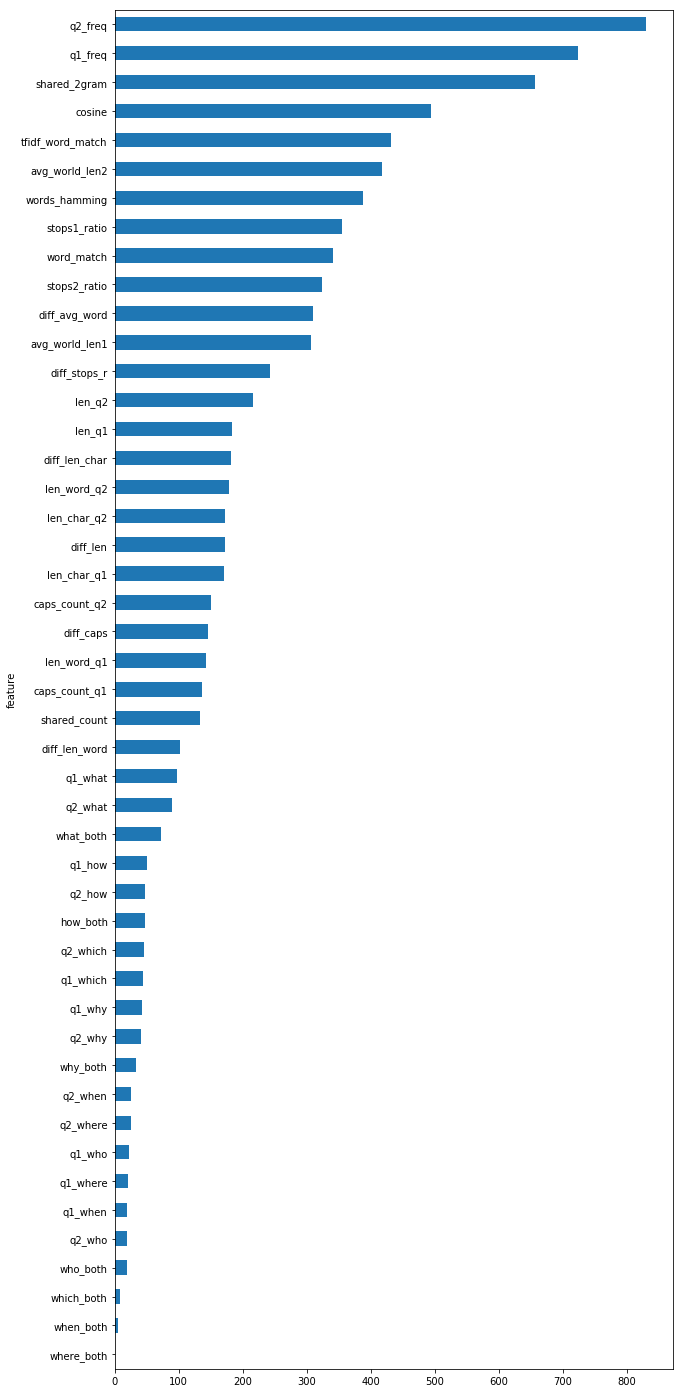

In [30]:
print("Writing output...")
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = preds *.75
sub.to_csv("xgb_seed{}_n{}.csv".format(RS, ROUNDS), index=False)

print("Features importances...")
importance = clr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')